# Geron's Chapter 15: Modified for multivariate series (2 in, 2 out)

n_steps != None anymore for cases also

**TODO**: Still need a clear distinction between different classes of models that take in multivariate multi-step input

Code borrows heavily from Aurelien Geron's 2nd edition: https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

### TWO problems

1. Random seed same leads to the same time series. Changed it.
2. For arrays with dimensions > 2, hstack always adds arrays along the 2nd axis (or [1]). Had to use:
```python
np.stack((array1, array2), axis=-1)
```
to make sure that the arrays were being stacked along the last axis.

In [3]:
n_steps = 50

## SERIES 1
np.random.seed(42)
series = generate_time_series(10000, n_steps + 1)

## SERIES 2
np.random.seed(11)
series2 = generate_time_series(10000, n_steps + 1)

## Train, validation, test split
np.random.seed(42)
X_train, y_train = np.stack((series[:7000, :n_steps, -1],    series2[:7000, :n_steps, -1]),axis=-1),     np.hstack((series[:7000, -1],     series2[:7000, -1]))
X_valid, y_valid = np.stack((series[7000:9000, :n_steps,-1], series2[7000:9000, :n_steps, -1]),axis=-1), np.hstack((series[7000:9000, -1], series2[7000:9000, -1]))
X_test,  y_test  = np.stack((series[9000:, :n_steps, -1],    series2[9000:, :n_steps, -1]),axis=-1)   ,  np.hstack((series[9000:, -1],    series2[9000:, -1]))

In [4]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(7000, 50, 2) (7000, 2)
(2000, 50, 2) (2000, 2)
(1000, 50, 2) (1000, 2)


Saving figure time_series_plot


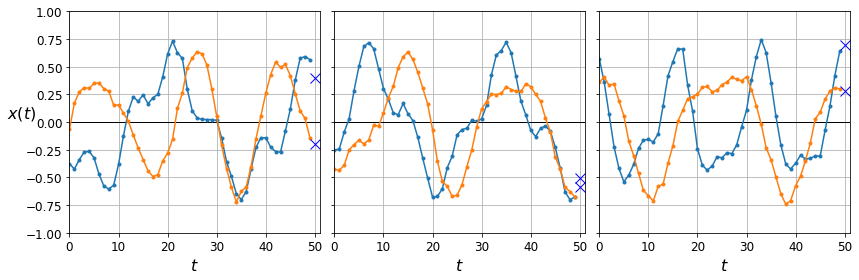

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
    plot_series(X_valid[col, :, 1], y_valid[col, 1],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [6]:
y_pred  = X_valid[:, -1, 0]
y_pred2 = X_valid[:, -1, 1]

print(y_pred.shape, y_pred2.shape)

print(f"Series 1: {np.mean(keras.losses.mean_squared_error(y_valid[:,0], y_pred))}")
print(f"Series 2: {np.mean(keras.losses.mean_squared_error(y_valid[:,1], y_pred2))}")

(2000,) (2000,)
Series 1: 0.020211365073919296
Series 2: 0.020139534026384354


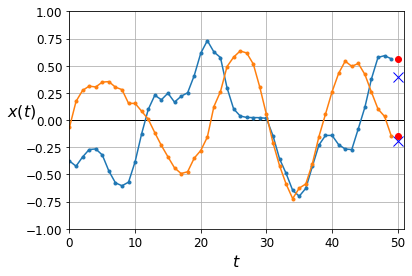

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0])
plot_series(X_valid[0, :, 1], y_valid[0, 1], y_pred2[0])
plt.show()

### Dense layer with one neuron = LINEAR regression

Now adapted for **multivariate regression**

Linear predictions:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

# Multivariate shapes
n_input_features  = 2
n_output_features = 2

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, n_input_features]),
    keras.layers.Dense(n_output_features)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 49us/sample - loss: 0.1860 - val_loss: 0.0701
Epoch 2/20
7000/7000 [==============================] - 0s 33us/sample - loss: 0.0503 - val_loss: 0.0392
Epoch 3/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0311 - val_loss: 0.0264
Epoch 4/20
7000/7000 [==============================] - 0s 32us/sample - loss: 0.0215 - val_loss: 0.0188
Epoch 5/20
7000/7000 [==============================] - 0s 31us/sample - loss: 0.0160 - val_loss: 0.0146
Epoch 6/20
7000/7000 [==============================] - 0s 32us/sample - loss: 0.0129 - val_loss: 0.0124
Epoch 7/20
7000/7000 [==============================] - 0s 32us/sample - loss: 0.0110 - val_loss: 0.0107
Epoch 8/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0097 - val_loss: 0.0095
Epoch 9/20
7000/7000 [==============================] - 0s 32us/sample - loss: 0.0087 - val_loss: 0.0085
Epoch 1

In [9]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 18us/sample - loss: 0.0043


0.004270456399768591

## Model summary and plot with shapes

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 202
Trainable params: 202
Non-trainable params: 0
_________________________________________________________________


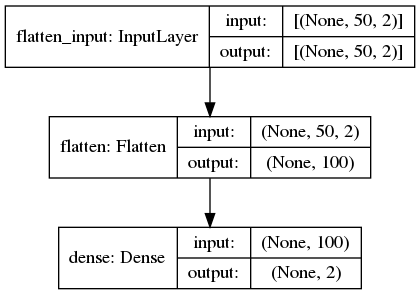

In [11]:
# !pip install pydot --- otherwise won't work
keras.utils.plot_model(model, 'dense_50.png', show_shapes=True)

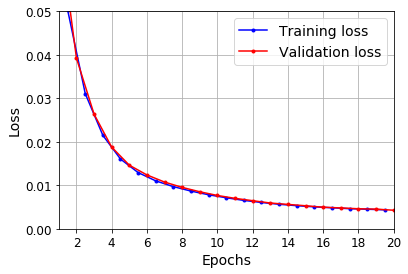

In [12]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

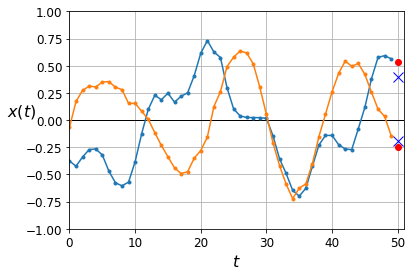

In [13]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plot_series(X_valid[0, :, 1], y_valid[0, 1], y_pred[0, 1])
plt.show()

### Using a Simple RNN

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

# Multivariate shapes
n_input_features  = 2
n_output_features = 2

model = keras.models.Sequential([
    keras.layers.SimpleRNN(n_output_features, input_shape=[None, n_input_features])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/10
7000/7000 [==============================] - 2s 327us/sample - loss: 0.0478 - val_loss: 0.0220
Epoch 2/10
7000/7000 [==============================] - 2s 251us/sample - loss: 0.0190 - val_loss: 0.0165
Epoch 3/10
7000/7000 [==============================] - 2s 253us/sample - loss: 0.0155 - val_loss: 0.0143
Epoch 4/10
7000/7000 [==============================] - 2s 262us/sample - loss: 0.0139 - val_loss: 0.0132
Epoch 5/10
7000/7000 [==============================] - 2s 259us/sample - loss: 0.0131 - val_loss: 0.0125
Epoch 6/10
7000/7000 [==============================] - 2s 252us/sample - loss: 0.0125 - val_loss: 0.0121
Epoch 7/10
7000/7000 [==============================] - 2s 245us/sample - loss: 0.0122 - val_loss: 0.0118
Epoch 8/10
7000/7000 [==============================] - 2s 245us/sample - loss: 0.0119 - val_loss: 0.0116
Epoch 9/10
7000/7000 [==============================] - 2s 255us/sample - loss: 0.0117 - val_loss: 0.011

In [15]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 115us/sample - loss: 0.0113


0.011345229506492615

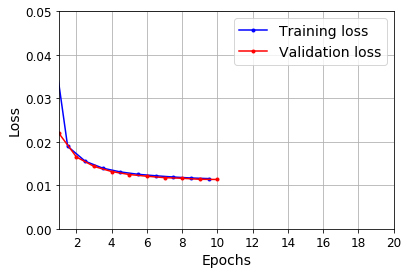

In [16]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

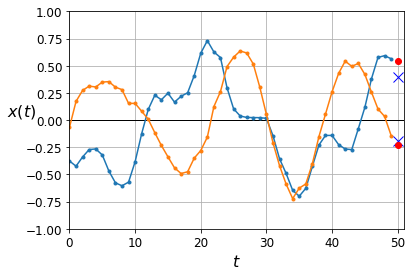

In [17]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plot_series(X_valid[0, :, 1], y_valid[0, 1], y_pred[0, 1])
plt.show()

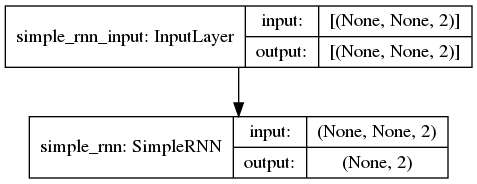

In [18]:
# !pip install pydot --- otherwise won't work
keras.utils.plot_model(model, 'rnn_1.png', show_shapes=True)

## Deep RNNs

In [55]:
np.random.seed(42)
tf.random.set_seed(42)

# Multivariate shapes
n_input_features  = 2
n_output_features = 2

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, n_input_features]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(n_output_features)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 418us/sample - loss: 0.0230 - val_loss: 0.0073
Epoch 2/20
7000/7000 [==============================] - 2s 328us/sample - loss: 0.0058 - val_loss: 0.0048
Epoch 3/20
7000/7000 [==============================] - 2s 329us/sample - loss: 0.0045 - val_loss: 0.0042
Epoch 4/20
7000/7000 [==============================] - 2s 327us/sample - loss: 0.0041 - val_loss: 0.0039
Epoch 5/20
7000/7000 [==============================] - 2s 335us/sample - loss: 0.0039 - val_loss: 0.0037
Epoch 6/20
7000/7000 [==============================] - 2s 345us/sample - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
7000/7000 [==============================] - 2s 332us/sample - loss: 0.0037 - val_loss: 0.0037
Epoch 8/20
7000/7000 [==============================] - 2s 335us/sample - loss: 0.0037 - val_loss: 0.0038
Epoch 9/20
7000/7000 [==============================] - 2s 329us/sample - loss: 0.0037 - val_loss: 0.003

In [56]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 152us/sample - loss: 0.0033


0.003307525176554918

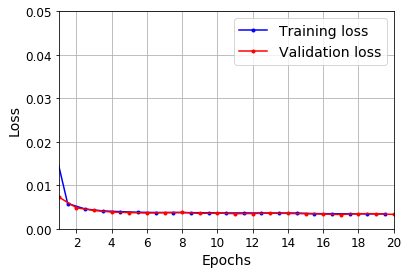

In [57]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

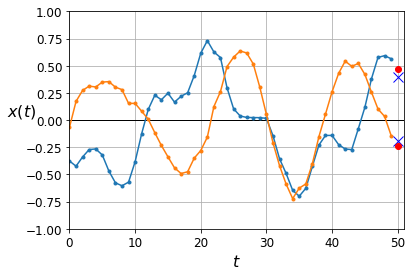

In [58]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plot_series(X_valid[0, :, 1], y_valid[0, 1], y_pred[0, 1])
plt.show()

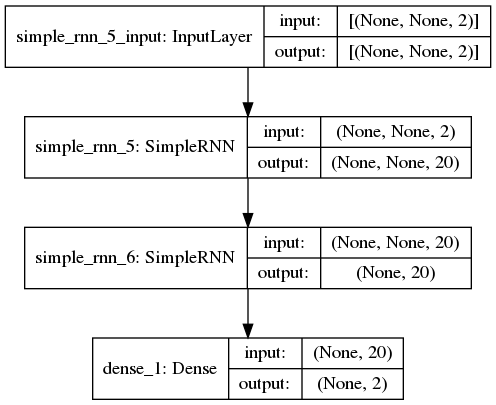

In [59]:
# !pip install pydot --- otherwise won't work
keras.utils.plot_model(model, 'rnn_2_dense_end.png', show_shapes=True)

## MULTI-STEP forecasting

## Method 1: 

1. Take models from before.

2. Run a loop over 10 points to get prediction for each point

In [73]:
np.random.seed(43) # not 42, as it would give the first series in the train set
series = generate_time_series(1, n_steps + 10)

np.random.seed(12)
series2 = generate_time_series(1, n_steps + 10)

X_new,  Y_new  = np.stack((series[:, :n_steps, -1], series2[:, :n_steps, -1]),axis=-1)   , np.stack((series[:, n_steps:, -1], series2[:, n_steps:, -1]), axis=-1)
X = X_new

for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:, :])[:, np.newaxis, :]
    print(y_pred_one.shape)
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)


In [74]:
Y_pred.shape

(1, 10, 2)

Saving figure forecast_ahead_plot


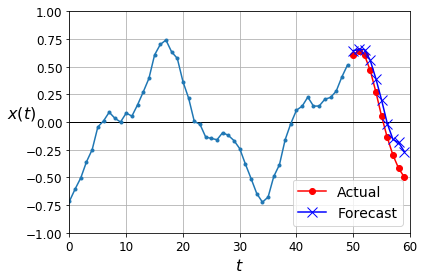

In [75]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Saving figure forecast_ahead_plot2


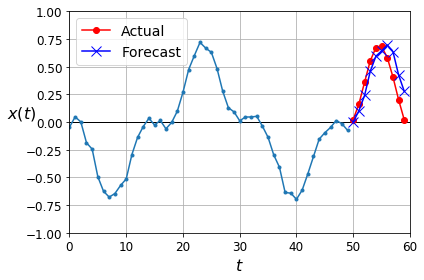

In [76]:
def plot_multiple_forecasts2(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 1])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 1], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 1], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
    
    
plot_multiple_forecasts2(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot2")
plt.show()

## Method 2

1. Predict 10 steps at ONCE.
2. Have to train a NEW model now, cannot use previous one.

This took the longest time because had to use `np.stack` instead of np.hstack for y_train, y_valid, y_test also since there are 3 axis dimensions there!!

Also, forgot to change the neuron dimension inside Dense to n_output_features from 1.

Now let's create an RNN that predicts all 10 next values at once:

In [42]:
n_steps = 50

## SERIES 1
np.random.seed(42)
series = generate_time_series(10000, n_steps + 10)

## SERIES 2
np.random.seed(11)
series2 = generate_time_series(10000, n_steps + 10)

## Train, validation, test split
# X's remain the same... notice the change in y-indices!!

np.random.seed(42)
X_train, y_train = np.stack((series[:7000, :n_steps, -1],    series2[:7000, :n_steps, -1]),axis=-1),     np.stack((series[:7000, -10:, -1],    series2[:7000, -10:, -1]), axis=-1)
X_valid, y_valid = np.stack((series[7000:9000, :n_steps,-1], series2[7000:9000, :n_steps, -1]),axis=-1), np.stack((series[7000:9000, -10:, -1],series2[7000:9000, -10:, -1]), axis=-1)
X_test,  y_test  = np.stack((series[9000:, :n_steps, -1],    series2[9000:, :n_steps, -1]),axis=-1)   ,  np.stack((series[9000:, -10:, -1],    series2[9000:, -10:, -1]), axis=-1)

In [36]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(7000, 50, 2) (7000, 10, 2)
(2000, 50, 2) (2000, 10, 2)
(1000, 50, 2) (1000, 10, 2)


## This was giving a whole lot of issues

Geron's earlier version had different layers that are commented out now.

His new version was difficult to fit with dimensions. Finally had to introduce n_steps in input_shape 
in the first layers. 

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

n_output = y_valid.shape[1] * y_valid.shape[2]

y_train = y_train.reshape((y_train.shape[0], n_output))
y_valid = y_valid.reshape((y_valid.shape[0], n_output))

print(y_train.shape, y_valid.shape)
print(X_train.shape)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, recurrent_dropout=0.2, return_sequences=True, input_shape=(n_steps, n_input_features)), # shouldn't None = n_steps????? That's what I understand from Brownlee and Chollet's book
    keras.layers.SimpleRNN(32, recurrent_dropout=0.2, dropout=0.2),#, return_sequences=True),
    #keras.layers.TimeDistributed(keras.layers.Dense(n_output_features)),
    #keras.layers.Lambda(lambda y_pred: y_pred[:, -10:, :]) # added a column for feature axes
    #keras.layers.Dense(32),
    #keras.layers.BatchNormalization(),
    keras.layers.Dense(n_output)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

(7000, 20) (2000, 20)
(7000, 50, 2)
Train on 7000 samples, validate on 2000 samples
Epoch 1/10
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.2545 - val_loss: 0.1052
Epoch 2/10
7000/7000 [==============================] - 6s 861us/sample - loss: 0.1145 - val_loss: 0.0737
Epoch 3/10
7000/7000 [==============================] - 6s 847us/sample - loss: 0.0885 - val_loss: 0.0591
Epoch 4/10
7000/7000 [==============================] - 6s 865us/sample - loss: 0.0772 - val_loss: 0.0545
Epoch 5/10
7000/7000 [==============================] - 6s 839us/sample - loss: 0.0698 - val_loss: 0.0520
Epoch 6/10
7000/7000 [==============================] - 6s 828us/sample - loss: 0.0668 - val_loss: 0.0504
Epoch 7/10
7000/7000 [==============================] - 6s 836us/sample - loss: 0.0633 - val_loss: 0.0492
Epoch 8/10
7000/7000 [==============================] - 6s 826us/sample - loss: 0.0606 - val_loss: 0.0491
Epoch 9/10
7000/7000 [==============================] - 6s 852us/sampl

In [38]:
np.random.seed(43) # not 42, as it would give the first series in the train set
series = generate_time_series(1, 50 + 10)

np.random.seed(12)
series2 = generate_time_series(1, 50 + 10)

X_new, Y_new  = np.stack((series[:, :50, -1], series2[:, :50, -1]),axis=-1), np.stack((series[:, -10:, -1], series2[:, -10:, -1]), axis=-1)
X = X_new

Y_pred = model.predict(X_new)#[:, :]
Y_pred.shape

(1, 20)

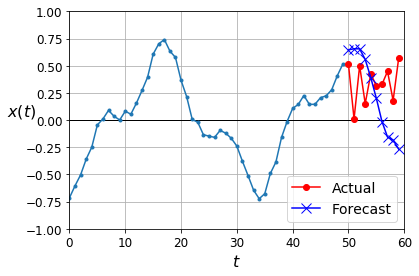

In [39]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :10], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

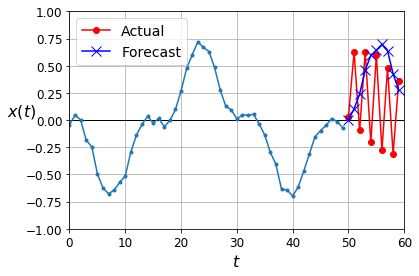

In [40]:
def plot_multiple_forecasts2(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 1])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, 10:], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 1], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts2(X_new, Y_new, Y_pred)
plt.show()

### New metrics

In [44]:
def last_10_time_steps_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -10:], Y_pred[:, -10:])

In [45]:
def last_5_time_steps_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -5:], Y_pred[:, -5:])

## Method 3

Goal: Forecast 10:59 based on 0:49.

Previously, 50:59 was being predicted by 0:49.

Now let's create an RNN that predicts the input sequence, shifted 10 steps into the future. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 10 to 59 based on time steps 0 to 49 (the time steps 10 to 49 are in the input, but the model is causal so at any time step it cannot see the future inputs):

In [46]:
n_steps = 50

## SERIES 1
np.random.seed(42)
series = generate_time_series(10000, n_steps + 10)

## SERIES 2
np.random.seed(11)
series2 = generate_time_series(10000, n_steps + 10)

## Train, validation, test split
# X's remain the same... notice the change in y-indices!!

np.random.seed(42)
X_train, y_train = np.stack((series[:7000, :n_steps, -1],    series2[:7000, :n_steps, -1]),axis=-1),     np.stack((series[:7000,  10:, -1],    series2[:7000,  10:, -1]), axis=-1)
X_valid, y_valid = np.stack((series[7000:9000, :n_steps,-1], series2[7000:9000, :n_steps, -1]),axis=-1), np.stack((series[7000:9000,  10:, -1],series2[7000:9000,  10:, -1]), axis=-1)
X_test,  y_test  = np.stack((series[9000:, :n_steps, -1],    series2[9000:, :n_steps, -1]),axis=-1)   ,  np.stack((series[9000:,  10:, -1],    series2[9000:,  10:, -1]), axis=-1)

In [31]:
#np.random.seed(42)

#n_steps = 50
#series = generate_time_series(10000, n_steps + 10)
#X_train, Y_train = series[:7000, :n_steps], series[:7000, 10:]
#X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, 10:]
#X_test, Y_test = series[9000:, :n_steps], series[9000:, 10:]

In [47]:
X_train.shape, y_train.shape

((7000, 50, 2), (7000, 50, 2))

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, n_input_features]),
    keras.layers.SimpleRNN(20, recurrent_dropout=0.2, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_output_features))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 892us/sample - loss: 0.1071 - last_10_time_steps_mse: 0.1040 - val_loss: 0.0693 - val_last_10_time_steps_mse: 0.0642
Epoch 2/20
7000/7000 [==============================] - 5s 748us/sample - loss: 0.0697 - last_10_time_steps_mse: 0.0644 - val_loss: 0.0653 - val_last_10_time_steps_mse: 0.0589
Epoch 3/20
7000/7000 [==============================] - 5s 732us/sample - loss: 0.0658 - last_10_time_steps_mse: 0.0588 - val_loss: 0.0640 - val_last_10_time_steps_mse: 0.0564
Epoch 4/20
7000/7000 [==============================] - 5s 738us/sample - loss: 0.0648 - last_10_time_steps_mse: 0.0576 - val_loss: 0.0636 - val_last_10_time_steps_mse: 0.0560
Epoch 5/20
7000/7000 [==============================] - 5s 717us/sample - loss: 0.0642 - last_10_time_steps_mse: 0.0566 - val_loss: 0.0629 - val_last_10_time_steps_mse: 0.0549
Epoch 6/20
7000/7000 [==============================] - 5s 727us/sample 

In [49]:
np.random.seed(43) # not 42, as it would give the first series in the train set
series = generate_time_series(1, 50 + 10)

np.random.seed(12)
series2 = generate_time_series(1, 50 + 10)

X_new, Y_new  = np.stack((series[:, :50, -1], series2[:, :50, -1]),axis=-1),      np.stack((series[:, 50:, -1], series2[:, 50:, -1]), axis=-1)
X = X_new

Y_pred = model.predict(X_new)[:, -10:, :]

Saving figure forecast_ahead_plot


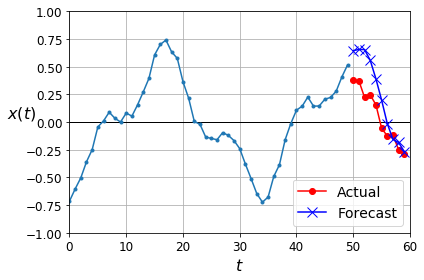

In [51]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Saving figure forecast_ahead_plot2


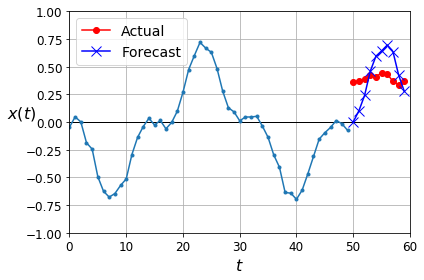

In [52]:
def plot_multiple_forecasts2(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 1])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 1], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 1], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
    
    
plot_multiple_forecasts2(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot2")
plt.show()

# LSTMs

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, n_input_features]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_output_features))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0904 - last_10_time_steps_mse: 0.0875 - val_loss: 0.0728 - val_last_10_time_steps_mse: 0.0675
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0712 - last_10_time_steps_mse: 0.0660 - val_loss: 0.0692 - val_last_10_time_steps_mse: 0.0630
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0680 - last_10_time_steps_mse: 0.0616 - val_loss: 0.0662 - val_last_10_time_steps_mse: 0.0586
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0649 - last_10_time_steps_mse: 0.0577 - val_loss: 0.0627 - val_last_10_time_steps_mse: 0.0546
Epoch 5/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0605 - last_10_time_steps_mse: 0.0517 - val_loss: 0.0575 - val_last_10_time_steps_mse: 0.0469
Epoch 6/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0

In [98]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 225us/sample - loss: 0.0400 - last_10_time_steps_mse: 0.0246


[0.04003534349799156, 0.024628434]

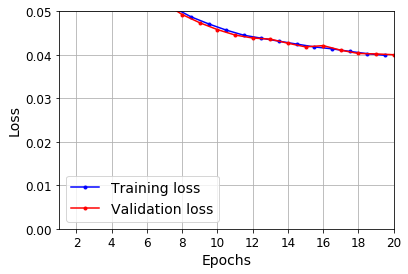

In [99]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [55]:
np.random.seed(43) # not 42, as it would give the first series in the train set
series = generate_time_series(1, 50 + 10)

np.random.seed(12)
series2 = generate_time_series(1, 50 + 10)

X_new, Y_new  = np.stack((series[:, :50, -1], series2[:, :50, -1]),axis=-1),      np.stack((series[:, 50:, -1], series2[:, 50:, -1]), axis=-1)
X = X_new

Y_pred = model.predict(X_new)[:, -10:, :]

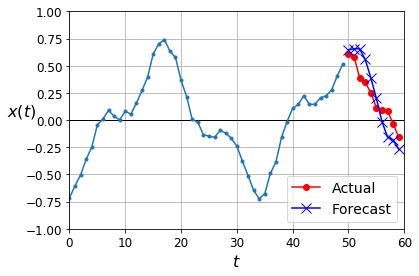

In [56]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

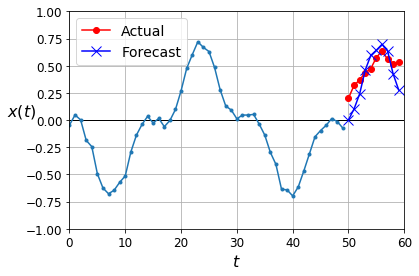

In [57]:
plot_multiple_forecasts2(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2----|      |-----5---...         |----23-----|
        |-----1----|      |-----4-----|   ...   |-----22----|
  |-----0----|      |-----3----|      |---...-21---|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59

Output:

X: 0  1  2  3  4  5  ... 19 20 21 22 23
Y: 13 15 17 19 21 23 ... 51 53 55 57 59
```

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="VALID",
                        input_shape=[None, n_input_features]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_output_features))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_5_time_steps_mse])
history = model.fit(X_train, y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0808 - last_5_time_steps_mse: 0.0794 - val_loss: 0.0688 - val_last_5_time_steps_mse: 0.0649
Epoch 2/20
7000/7000 [==============================] - 5s 768us/sample - loss: 0.0661 - last_5_time_steps_mse: 0.0620 - val_loss: 0.0618 - val_last_5_time_steps_mse: 0.0569
Epoch 3/20
7000/7000 [==============================] - 5s 766us/sample - loss: 0.0580 - last_5_time_steps_mse: 0.0523 - val_loss: 0.0537 - val_last_5_time_steps_mse: 0.0468
Epoch 4/20
7000/7000 [==============================] - 5s 776us/sample - loss: 0.0522 - last_5_time_steps_mse: 0.0457 - val_loss: 0.0500 - val_last_5_time_steps_mse: 0.0428
Epoch 5/20
7000/7000 [==============================] - 5s 772us/sample - loss: 0.0493 - last_5_time_steps_mse: 0.0423 - val_loss: 0.0482 - val_last_5_time_steps_mse: 0.0412
Epoch 6/20
7000/7000 [==============================] - 5s 775us/sample - loss: 0.04

In [60]:
model.evaluate(X_valid, y_valid[:, 3::2])

2000/2000 [==============================] - 1s 346us/sample - loss: 0.0366 - last_5_time_steps_mse: 0.0269


[0.036616235613822934, 0.026902795]

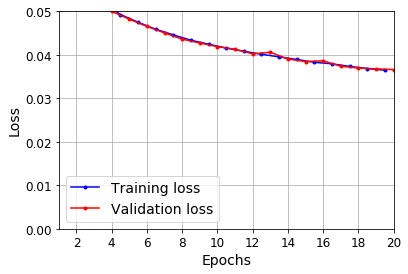

In [61]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [62]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          180       
_________________________________________________________________
gru (GRU)                    (None, None, 20)          2520      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 2)           42        
Total params: 5,262
Trainable params: 5,262
Non-trainable params: 0
_________________________________________________________________


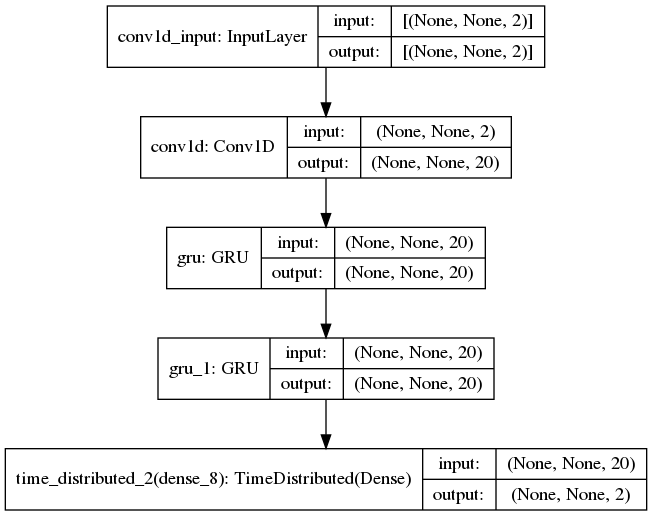

In [63]:
keras.utils.plot_model(model, 'cnn.png', show_shapes=True)

## WaveNet

```
C2     /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\ 
      /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59

Output:

X: 0  1  2  3  4  5  ... 19 20 21 22 23
Y: 13 15 17 19 21 23 ... 51 53 55 57 59
```

## Conv1D output has filters as last dimension so it has to be changed to n_output_features

In [69]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, n_input_features]))
for rate in (1, 2, 4, 8) * 2:
    #model.add(keras.layers.Lambda(
    #    lambda inputs: keras.backend.temporal_padding(inputs, (rate, 0))))
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=n_output_features, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 484us/sample - loss: 0.0810 - last_10_time_steps_mse: 0.0751 - val_loss: 0.0593 - val_last_10_time_steps_mse: 0.0513
Epoch 2/20
7000/7000 [==============================] - 2s 345us/sample - loss: 0.0549 - last_10_time_steps_mse: 0.0454 - val_loss: 0.0507 - val_last_10_time_steps_mse: 0.0406
Epoch 3/20
7000/7000 [==============================] - 2s 340us/sample - loss: 0.0487 - last_10_time_steps_mse: 0.0376 - val_loss: 0.0469 - val_last_10_time_steps_mse: 0.0358
Epoch 4/20
7000/7000 [==============================] - 2s 346us/sample - loss: 0.0460 - last_10_time_steps_mse: 0.0343 - val_loss: 0.0447 - val_last_10_time_steps_mse: 0.0331
Epoch 5/20
7000/7000 [==============================] - 2s 342us/sample - loss: 0.0446 - last_10_time_steps_mse: 0.0325 - val_loss: 0.0432 - val_last_10_time_steps_mse: 0.0312
Epoch 6/20
7000/7000 [==============================] - 2s 349us/sample 

In [70]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 154us/sample - loss: 0.0365 - last_10_time_steps_mse: 0.0222


[0.036486514538526534, 0.022176312]

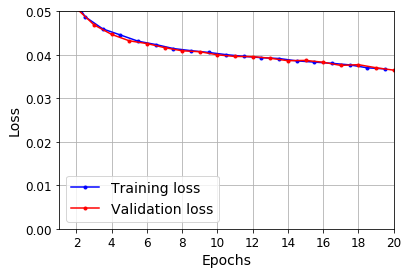

In [72]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [71]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, None, 20)          100       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 20)        

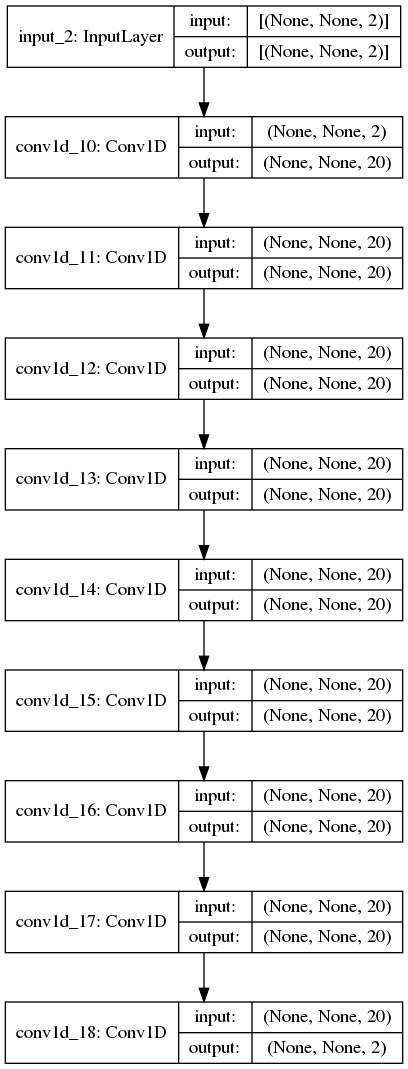

In [73]:
keras.utils.plot_model(model, 'cnn_wavenetsimple_causal.png', show_shapes=True)